<h1>Hypothesis: "Antartic locations with subterrainian lake will have flatter surafce ice slopes"</h1>

Sources:

https://nsidc.org/data/nsidc-0720/versions/1#anchor-data-access-tools

https://www.npolar.no/quantarctica/#toggle-id-15

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import raster_tools as rt

import cartopy.crs as ccrs

##### Load Data

In [2]:
# Load lakes
lakes2 = gpd.read_file('data/Quantarctica3/Quantarctica3/Glaciology/Subglacial Lakes/SubglacialLakes_WrightSiegert.shp')
# regex replace spaces in LENGTH_M column
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace('28100 + 4000', '28100')
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace('<', '')
lakes2['LENGTH_M'] = lakes2['LENGTH_M'].str.replace(' ', '')
lakes2['LENGTH_M'] = pd.to_numeric(lakes2['LENGTH_M'], errors='coerce')
# make a new col claled SAT_DETECT with a value of 1 if the lake is detected by satellite (CLASS G) and 0 otherwise
lakes2['SAT_DETECT'] = np.where(lakes2['CLASS'] == 'G', 1, 0)

In [3]:
# load ice boundaries
ice_bounds = gpd.read_file('data/Quantarctica3/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceBoundaries_Antarctica_v2.shp')

In [4]:
# load flow speed
ice_vel_450 = rt.Raster('data/Quantarctica3/Quantarctica3/Glaciology/MEaSUREs Ice Flow Velocity/MEaSUREs_IceFlowSpeed_450m.tif')

In [5]:
# load DEM
dem = rt.Raster('data/dem/rema_mosaic_500m_v2.0_filled_cop30_dem.tif')

In [6]:
# get slope from dem
slope = rt.surface.slope(dem)

In [7]:
lakes2

,TALLY,NAME,LAT,LON,LENGTH_M,CLASS,WIDTH_M,DEPTH_M,AREA_KM2,VOLUME_KM3,ICETHKNS_M,REFERENCES,geometry,SAT_DETECT
0,1,Sovetskaya Lake,-78.100,88.500,75000.0,F,35000.0,NaN,1600.0,NaN,4200.0,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),0
1,2,Lake Vostok,-78.150,104.500,280000.0,F,44000.0,1067.0,14000.0,5400.0,3945.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),0
2,3,SPRI-3,-76.570,124.800,5000.0,A,NaN,NaN,NaN,NaN,3621.0,Oswald and Robin (1973),POINT (1203517.434 -836466.407),0
3,4,SPRI-4,-73.280,157.280,3500.0,A,NaN,NaN,NaN,NaN,2827.0,Oswald and Robin (1973),POINT (706469.226 -1687214.515),0
4,5,SPRI-5,-77.200,119.270,10000.0,B,NaN,NaN,NaN,NaN,3835.0,Oswald and Robin (1973),POINT (1218054.666 -682702.029),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500.0,A,NaN,NaN,NaN,NaN,3521.0,Wright et al. (2012),POINT (1470914.122 -423028.361),0
375,376,R15Ea_4,-74.084,100.818,1800.0,A,NaN,NaN,NaN,NaN,3523.0,Wright et al. (2012),POINT (1709145.571 -326593.471),0
376,377,Site A,-67.800,112.540,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1
377,378,Site B,-67.870,113.530,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1


##### Plotting

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from raster_tools import Raster, open_dataset

import cartopy.crs as ccrs

def plot_with_basemap(title, rs=None, vector=None, vect_col=None, rs_cmap='gist_earth', vect_cmap='viridis', vmin=None, vmax=None, rs_mask=False, rs_log_scale=False):

    # Load basemap
    world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
    world = world.set_crs(epsg=4269)
    world = world.to_crs(epsg=3031)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})

    world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.5, color='blue')

    if rs_mask and rs is not None:
        rs = rt.clipping.mask(world, rs)

    if rs is not None:
        if vmin is None and vmax is None:
            rs.plot(ax=ax, cmap=rs_cmap, transform=ccrs.SouthPolarStereo(), alpha=0.7)
        else:
            rs.plot(ax=ax, cmap=rs_cmap, transform=ccrs.SouthPolarStereo(), alpha=0.7, vmin=vmin, vmax=vmax)

    if vector is not None:
        vector.plot(ax=ax, column=vect_col, cmap=vect_cmap, transform=ccrs.SouthPolarStereo(), legend=True, markersize=5)

    # Adjust map extent
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

    ax.set_title(title)
    plt.show()

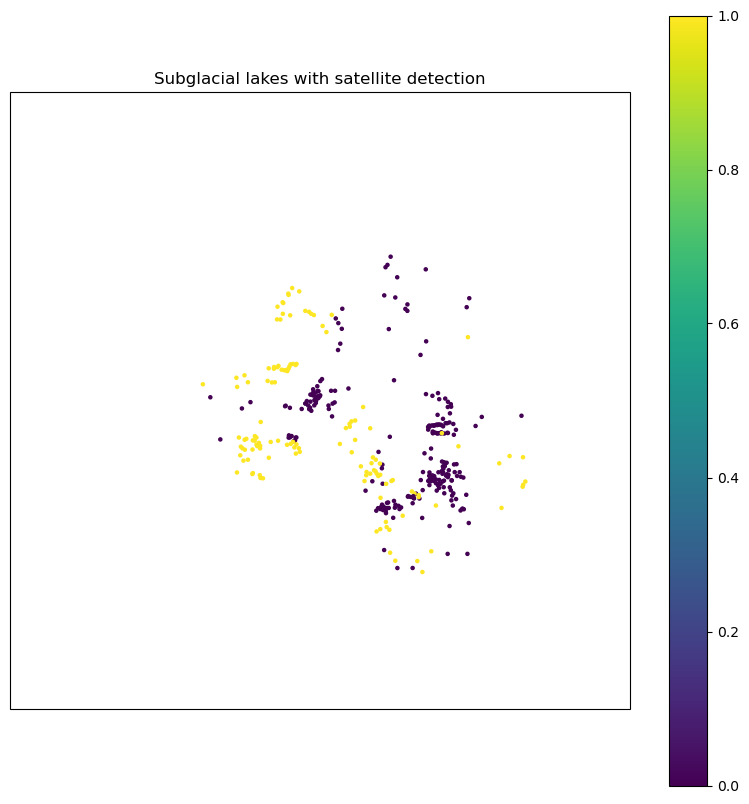

In [24]:
plot_with_basemap('Subglacial lakes with satellite detection',vector=lakes2, vect_col='SAT_DETECT', vect_cmap='viridis')

<h3>Where are subglacial lakes?</h3>

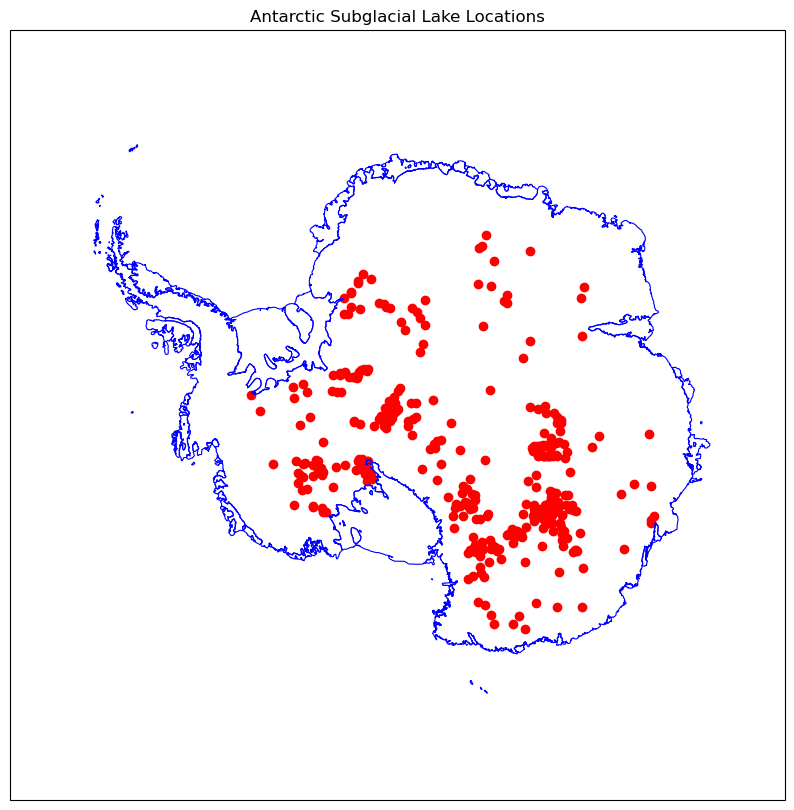

In [25]:
world = gpd.read_file('data\coastline\ADD_Coastline_low_res_polygon.shp')
world = world.to_crs(epsg=3031)
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')
lakes2.plot(ax=ax, color='red',
               legend_kwds={'label': "Ice Thickness (m)"}, transform=ccrs.SouthPolarStereo())

# Adjust map extent if needed
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Antarctic Subglacial Lake Locations")
plt.show()

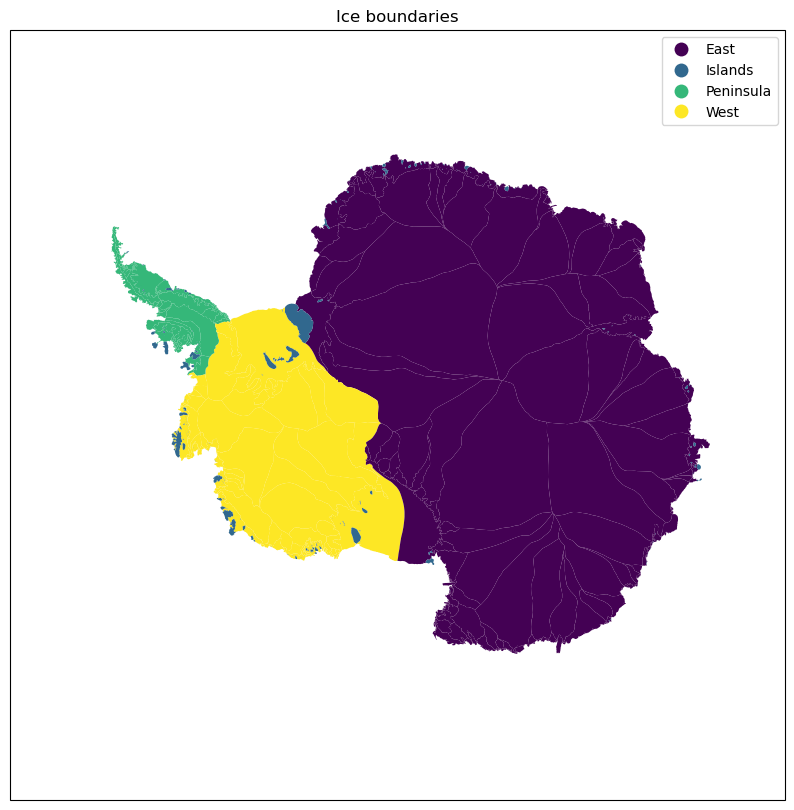

In [26]:
plot_with_basemap('Ice boundaries',vector=ice_bounds, vect_col='Regions', vect_cmap='viridis')

<h3>What is the slope of Antarctica?</h3>

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\dask\array\core.py:1988: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  self, index2 = slice_with_bool_dask_array(self, index2)
c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\dask\array\core.py:1988: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the lar

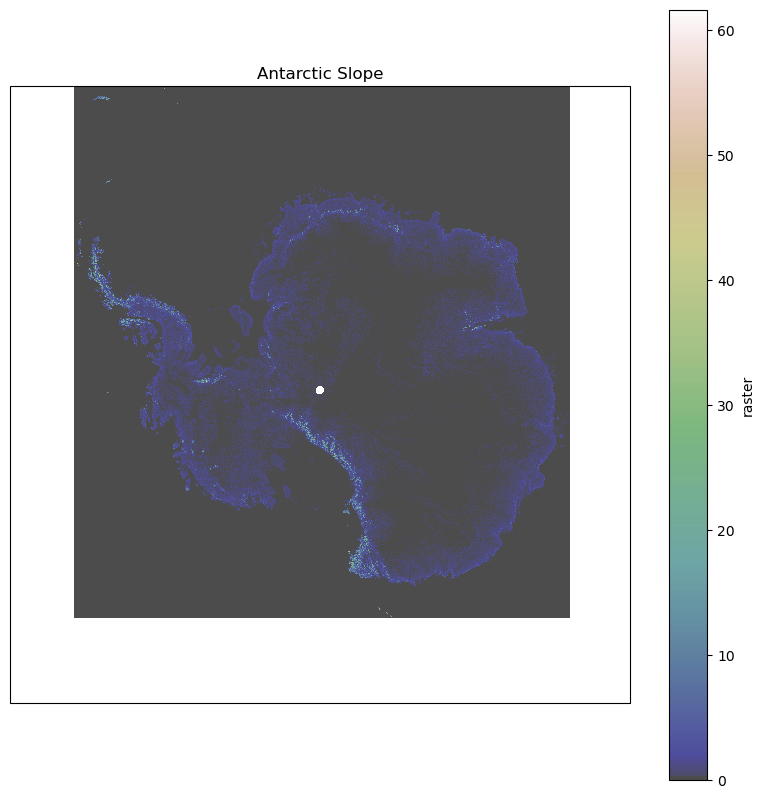

In [23]:
plot_with_basemap('Antarctic Slope',slope, rs_cmap='gist_earth', vmin=slope.min().compute(), vmax=slope.max().compute())

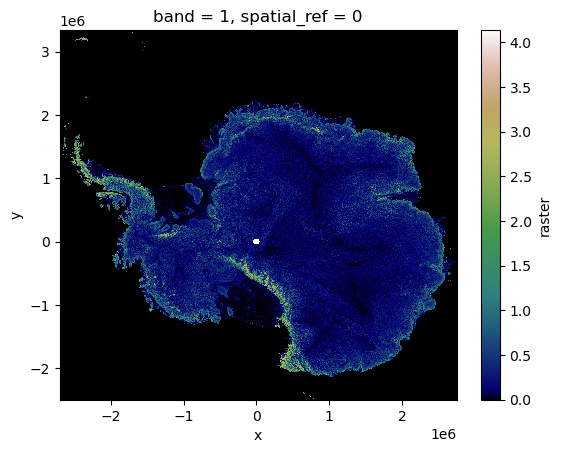

In [27]:
# log scale the slope for plotting
slope_log = np.log(slope + 1)
slope_log.plot(cmap='gist_earth')

In [31]:
lakes2

,TALLY,NAME,LAT,LON,LENGTH_M,CLASS,WIDTH_M,DEPTH_M,AREA_KM2,VOLUME_KM3,ICETHKNS_M,REFERENCES,geometry,SAT_DETECT
0,1,Sovetskaya Lake,-78.100,88.500,75000.0,F,35000.0,NaN,1600.0,NaN,4200.0,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),0
1,2,Lake Vostok,-78.150,104.500,280000.0,F,44000.0,1067.0,14000.0,5400.0,3945.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),0
2,3,SPRI-3,-76.570,124.800,5000.0,A,NaN,NaN,NaN,NaN,3621.0,Oswald and Robin (1973),POINT (1203517.434 -836466.407),0
3,4,SPRI-4,-73.280,157.280,3500.0,A,NaN,NaN,NaN,NaN,2827.0,Oswald and Robin (1973),POINT (706469.226 -1687214.515),0
4,5,SPRI-5,-77.200,119.270,10000.0,B,NaN,NaN,NaN,NaN,3835.0,Oswald and Robin (1973),POINT (1218054.666 -682702.029),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500.0,A,NaN,NaN,NaN,NaN,3521.0,Wright et al. (2012),POINT (1470914.122 -423028.361),0
375,376,R15Ea_4,-74.084,100.818,1800.0,A,NaN,NaN,NaN,NaN,3523.0,Wright et al. (2012),POINT (1709145.571 -326593.471),0
376,377,Site A,-67.800,112.540,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1
377,378,Site B,-67.870,113.530,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1


<h3>Do "flatter slopes" congregate above subglacial lakes?</h3>

Assign Slope value to each gdf point

In [ ]:
lake_coords = np.array([lakes2.geometry.x, lakes2.geometry.y]).T

lake_coords

array([[ 1.29699956e+06,  3.39631288e+04],
       [ 1.25080332e+06, -3.23479733e+05],
       [ 1.20351743e+06, -8.36466407e+05],
       [ 7.06469226e+05, -1.68721451e+06],
       [ 1.21805467e+06, -6.82702029e+05],
       [ 1.42630214e+06, -9.99449671e+05],
       [-9.23610778e+04, -1.59974079e+05],
       [ 1.60686305e+06, -1.08139627e+06],
       [ 1.10819174e+06, -9.20038510e+05],
       [ 1.21930809e+06, -9.32568681e+05],
       [ 1.24452105e+06, -9.22915550e+05],
       [ 1.27415713e+06, -9.12206913e+05],
       [ 1.30162654e+06, -8.34346730e+05],
       [ 1.29678286e+06, -9.76486461e+05],
       [ 1.57498266e+06, -8.92534397e+05],
       [ 1.05600034e+06, -1.06857087e+06],
       [ 5.76847605e+05, -9.32902935e+05],
       [ 1.28310945e+06, -1.03533881e+06],
       [ 1.25550141e+06, -8.77479738e+05],
       [ 1.25663594e+06, -9.11994544e+05],
       [ 1.25644935e+06, -9.29045063e+05],
       [ 1.34966080e+06, -9.34584298e+05],
       [ 1.35553340e+06, -7.94968736e+05],
       [ 1.

In [33]:
# Extract raster data and affine transform
slope_array = slope.to_numpy()  # Convert raster to a NumPy array
affine_transform = slope.affine  # Affine transform for mapping coordinates
nodata_value = slope.null_value  # No-data value

In [34]:
# Function to map geographic coordinates to array indices
def coords_to_indices(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

# Extract slope values for each lake point
lake_slopes = []
for geom in lakes2.geometry:
    row, col = coords_to_indices(geom.x, geom.y, affine_transform)
    if 0 <= row < slope_array.shape[1] and 0 <= col < slope_array.shape[2]:  # Check bounds
        value = slope_array[0, row, col]  # Access the value from the raster
        lake_slopes.append(value if value != nodata_value else None)
    else:
        lake_slopes.append(None)  # Out-of-bounds points

# Add extracted values to GeoDataFrame
lakes2["slope"] = lake_slopes


In [35]:
lakes2

,TALLY,NAME,LAT,LON,LENGTH_M,CLASS,WIDTH_M,DEPTH_M,AREA_KM2,VOLUME_KM3,ICETHKNS_M,REFERENCES,geometry,SAT_DETECT,slope
0,1,Sovetskaya Lake,-78.100,88.500,75000.0,F,35000.0,NaN,1600.0,NaN,4200.0,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),0,0.086016
1,2,Lake Vostok,-78.150,104.500,280000.0,F,44000.0,1067.0,14000.0,5400.0,3945.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),0,0.114682
2,3,SPRI-3,-76.570,124.800,5000.0,A,NaN,NaN,NaN,NaN,3621.0,Oswald and Robin (1973),POINT (1203517.434 -836466.407),0,0.029392
3,4,SPRI-4,-73.280,157.280,3500.0,A,NaN,NaN,NaN,NaN,2827.0,Oswald and Robin (1973),POINT (706469.226 -1687214.515),0,0.227904
4,5,SPRI-5,-77.200,119.270,10000.0,B,NaN,NaN,NaN,NaN,3835.0,Oswald and Robin (1973),POINT (1218054.666 -682702.029),0,0.057291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500.0,A,NaN,NaN,NaN,NaN,3521.0,Wright et al. (2012),POINT (1470914.122 -423028.361),0,0.095858
375,376,R15Ea_4,-74.084,100.818,1800.0,A,NaN,NaN,NaN,NaN,3523.0,Wright et al. (2012),POINT (1709145.571 -326593.471),0,0.056701
376,377,Site A,-67.800,112.540,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1,0.229883
377,378,Site B,-67.870,113.530,NaN,G,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1,0.525441


Next lets understand what slopes indicate

In [54]:
# create a 1km buffer around the lakes
# lakes2['geometry_buffer'] = lakes2.buffer(1000)

# get zonal states for the slope for all lakes
slope_zonal = rt.zonal.zonal_stats(lakes2, slope, stats=['mean', 'median', 'max', 'min'])

In [55]:
slope_zonal = slope_zonal.compute()
slope_zonal = slope_zonal['band_1']

In [53]:
slope_zonal

band_1                              
          mean    median       max       min
zone                                        
348   0.180767  0.180767  0.180767  0.180767
70    0.069198  0.069198  0.069198  0.069198
60    0.011084  0.011084  0.011084  0.011084
316   0.573157  0.573157  0.573157  0.573157
240   0.284154  0.284154  0.284154  0.284154
...        ...       ...       ...       ...
151   0.040296  0.040296  0.040296  0.040296
379   0.516714  0.516714  0.516714  0.516714
363   0.138681  0.138681  0.138681  0.138681
378   0.525441  0.525441  0.525441  0.525441
377   0.229883  0.229883  0.229883  0.229883

[379 rows x 4 columns]

In [56]:
slope_zonal['min'].sort_values(ascending=False)

zone
258    2.159162
278    1.563556
296    1.275975
317    1.064880
274    1.041516
         ...   
212         NaN
193         NaN
191         NaN
63          NaN
200         NaN
Name: min, Length: 379, dtype: float64

<Axes: xlabel='SAT_DETECT'>

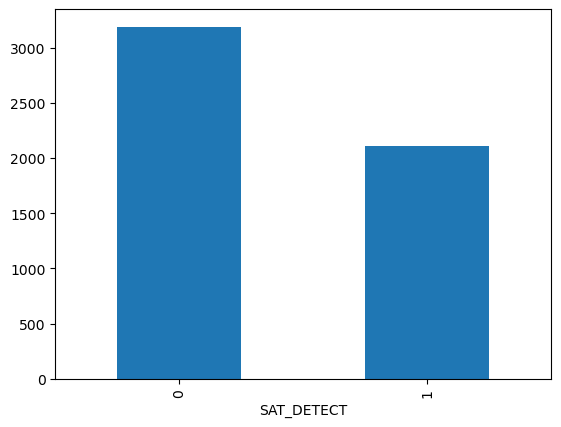

In [41]:
# plot average ICETHKNS_M vs CLASS
lakes2.groupby('SAT_DETECT')['ICETHKNS_M'].mean().plot(kind='bar')

In [42]:
# zonal stats for the lakes
zonal_stats = rt.zonal.zonal_stats(lakes2, dem, stats=['mean', 'max', 'min', 'std', 'median'])

In [43]:
zonal_stats.compute()

band_1                                           
             mean          max          min std       median
zone                                                        
348    291.671875   291.671875   291.671875 NaN   291.671875
70    1911.796875  1911.796875  1911.796875 NaN  1911.796875
60    1798.179688  1798.179688  1798.179688 NaN  1798.179688
316    380.187500   380.187500   380.187500 NaN   380.187500
240   1229.578125  1229.578125  1229.578125 NaN  1229.578125
...           ...          ...          ...  ..          ...
151   2752.164062  2752.164062  2752.164062 NaN  2752.164062
379    871.570312   871.570312   871.570312 NaN   871.570312
363   2217.820312  2217.820312  2217.820312 NaN  2217.820312
378    933.710938   933.710938   933.710938 NaN   933.710938
377   1052.968750  1052.968750  1052.968750 NaN  1052.968750

[379 rows x 5 columns]

In [60]:
slope_zonal['min'].mean()

0.16817166521899624

define "flatter" and see correlation between slope and lakes

In [71]:
slope_np = slope.to_numpy()
slope_np = slope_np.flatten()
slope_np = slope_np[~np.isnan(slope_np)]  # Remove NaN values
slope_np = slope_np[slope_np != -999999.0] # Remove fill values

In [72]:
# Summary statistics for raster
raster_mean = np.mean(slope_np)
raster_std = np.std(slope_np)
raster_min = np.min(slope_np)
raster_max = np.max(slope_np)

print(f"Raster Mean: {raster_mean}, Std Dev: {raster_std}, Min: {raster_min}, Max: {raster_max}")

Raster Mean: 0.24870854059471897, Std Dev: 1.2076309401356453, Min: 0.0, Max: 61.6018216800063


In [73]:
# Summary statistics for lakes2 slopes
point_mean = lakes2['slope'].mean()
point_std = lakes2['slope'].std()
point_min = lakes2['slope'].min()
point_max = lakes2['slope'].max()

print(f"Point Mean: {point_mean}, Std Dev: {point_std}, Min: {point_min}, Max: {point_max}")

Point Mean: 0.1681716652189962, Std Dev: 0.22513976947910488, Min: 0.0008522493294200378, Max: 2.159161736003703


answer hyp

In [79]:
import numpy as np

# Calculate a threshold for "flat" slopes
flat_threshold = np.percentile(slope_np, 25)  # Bottom 25% of slopes
print(f"Flat slope threshold: {flat_threshold}")

Flat slope threshold: 0.0010009160765785867


In [82]:
flat_lakes = lakes2[lakes2['slope'] <= flat_threshold]
flat_percentage = len(flat_lakes) / len(lakes2) * 100
print(f"{flat_percentage:.2f}% of lakes are located in flatter areas.")

0.26% of lakes are located in flatter areas.


In [89]:
lake_slopes_valid = lakes2['slope'].dropna()  # Remove NaN values
slope_np_valid = slope_np[~np.isnan(slope_np)]  # Ensure no NaN in raster slopes
slope_np_valid = slope_np_valid[slope_np_valid != -999999.0]  # Remove fill values

slope_np_valid

array([0.00089525, 0.00100092, 0.00100092, ..., 0.00096265, 0.00080696,
       0.00080696], dtype=float64)

In [88]:
print(f"Variance of lake slopes: {lake_slopes_valid.var()}")
print(f"Variance of raster slopes: {slope_np_valid.var()}")

Variance of lake slopes: 0.05068791580110448
Variance of raster slopes: 1.4583724875729027


In [ ]:
print(f"Number of lake slopes: {len(lake_slopes_valid)}")
print(f"Number of raster slopes: {len(slope_np_valid)}")

Number of lake slopes: 374
Number of raster slopes: 127284292


In [92]:
from scipy.stats import ttest_ind

# T-Test: Compare means of lake slopes and all raster slopes
t_stat, p_value = ttest_ind(lake_slopes_valid, slope_np_valid, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -6.9176725914752355, P-value: 2.0060453528593052e-11


negative t value suggests that lakes tend to be located in areas with flatter slopes

small p value indicates statistically signifigant result, not chance

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#put in this plot later

##### Proximity raster

In [31]:
lakes_vector = rt.Vector(lakes2)

In [32]:
# rasterize the lakes
lakes_raster = rt.rasterize.rasterize(lakes_vector, dem, field='TALLY')

In [34]:
prox_raster = rt.distance.pa_proximity(lakes_raster, target_values=np.arange(1, 380).astype(int))

# Load basemap
world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
world = world.set_crs(epsg=4269)
world = world.to_crs(epsg=3031)

# clip prox raster to world
# prox_raster = prox_raster.clip(world.geometry)
prox_clipped = rt.clipping.clip(world, prox_raster)

ValueError: cannot convert float NaN to integer

In [35]:
# Load Antarctic shapefile and transform to EPSG:3031
world = gpd.read_file('data/Quantarctica3/Quantarctica3/Miscellaneous/SimpleBasemap/ADD_DerivedLowresBasemap.shp')
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')

prox_clipped.plot(ax=ax, cmap='gist_earth', transform=ccrs.SouthPolarStereo(), alpha=0.8, nodata=0)

# Adjust map extent
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Proximity to Subglacial Lakes")
plt.show()

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

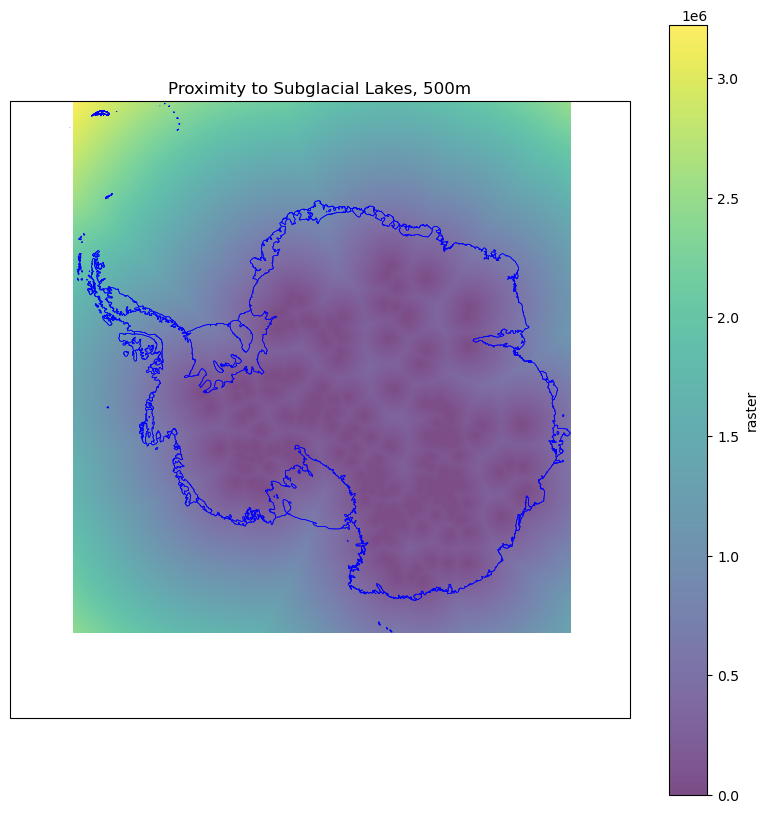

In [28]:
plot_with_basemap('Proximity to Subglacial Lakes, 500m', rs=prox_raster, rs_cmap='viridis', rs_mask=True)

------

##### Clustering

In [ ]:
# we will cluster the lakes from lakes2 gdf using kmeans.  the goal is to create a new column in the gdf called 'CLUSTER' that will have the cluster number for each lake, then plot the clusters on the map
from sklearn.cluster import KMeans

# get the coordinates of the lakes
lakes2['X'] = lakes2.geometry.x
lakes2['Y'] = lakes2.geometry.y

# create a new df with only the coordinates
X = lakes2[['X', 'Y']]
# fit the kmeans model
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
# get the cluster labels
lakes2['CLUSTER'] = kmeans.labels_

# Plot
plot_with_basemap('Antarctic Subglacial Lakes Clusters',vector=lakes2, vect_col='CLUSTER', vect_cmap='tab10')